In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
from torchvision.models import vgg19
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import numpy as np
from PIL import Image

VGG also has a batch normalized version. The paper didn't specify if batch norm was used

In [2]:
torch.cuda.set_device(0)

vgg = vgg19(True).eval().cuda()

In [3]:
preprocess = transforms.Compose([transforms.Resize(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

im_a = Image.open("./images/dog1.jpg")
im_a_tens = V(preprocess(im_a).unsqueeze(0)).cuda()
out = vgg(im_a_tens)
print('Prediction for cat.jpg is: %s'%(np.argmax(out.cpu().detach().numpy())))

im_b = Image.open("./images/dog2.jpg")
im_b_tens = V(preprocess(im_b).unsqueeze(0)).cuda()
out = vgg(im_b_tens)
print('Prediction for dog.jpg is: %s'%(np.argmax(out.cpu().detach().numpy())))

Prediction for cat.jpg is: 207
Prediction for dog.jpg is: 207


#### VGG is verified making correct predictions

## Now let's extract the features pyramid (section 3.1)
#### Check the VGG architecture

In [4]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

#### We want the outputs of the 5 ReLUs just before max pooling

In [5]:
feature_pyramid = []
def extract_feature(self, input, output):
    feature_pyramid.append(output)

layer_inds = [3, 8, 17, 26, 35]

for layer_ind in layer_inds:
    vgg.features[layer_ind].register_forward_hook(extract_feature)

In [6]:
feature_pyramid = []
vgg(im_a_tens)
vgg(im_b_tens)
feat_a = feature_pyramid[:5]
feat_b = feature_pyramid[5:]

and those are the relu1_1 ~ relu5_1 outputs of image A and B

### Generate common appearance
[Adaptive Instance Normalization [Huang et al. 2017]][1] is used for real time generation of common appearance. For the purpose of Neural Best Buddies, spatial mean and standard deviation are taken over both images, and the technique is only applied locally

[1]: https://arxiv.org/abs/1703.06868

In [7]:
class AdaIN(torch.nn.Module):
    def __init__(self):
        super(AdaIN, self).__init__()
        self.train(False)
        
    def forward(self, P, Q):
        assert (P.size() == Q.size())
        mu_a = torch.mean(P)
        mu_b = torch.mean(Q)
        mu_m = (mu_a + mu_b) / 2
        sig_a = torch.std(P)
        sig_b = torch.std(Q)
        sig_m = (sig_a + sig_b) / 2
        res = (P - mu_a) / sig_a * sig_m + mu_m
        return res

adain = AdaIN()

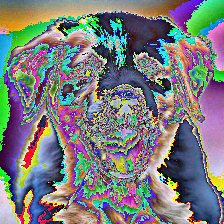

In [8]:
im_a_common = adain(im_a_tens, im_b_tens)
im_b_common = adain(im_b_tens, im_a_tens)

F.to_pil_image(im_a_common[0].cpu())

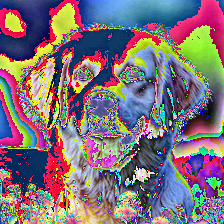

In [9]:
F.to_pil_image(im_b_common[0].cpu())

#### not sure if I implemented NBB version of AdaIN correctly, but we'll move on for now.

### Now the similarity metric: normalized cross-correlation of surrounding feature patches (after common appearance)

In [10]:
class NeuralBestBuddies(torch.nn.Module):
    def __init__(self):
        super(NeuralBestBuddies, self).__init__()
        self.train(False)
        
    def _get_neighborhood(self, P, i, j, neigh_rad):
        # 2
        return P.permute(1, 2, 0)[i - neigh_rad : i + neigh_rad + 1, j - neigh_rad : j + neigh_rad + 1].permute(2, 0, 1)
    
    
    def forward(self, Ps, Qs, neigh_rad):
        """
        args:
            P: 4D tensor of features
            Q: 4D tensor of features
            neigh_rad: int representing amount of surrounding neighbors to include in cross correlation.
                       so neigh_rad of 1 takes cross correlation of 3x3 patches of neurons
        output:
            NBB pairs
        """
        
        height = Ps.size()[2]
        width = Qs.size()[3]
        n_channels = Ps.size()[1]
        
        best_buddies = []
        
        for P, Q in zip(Ps, Qs):
            P_nearest = []
            Q_nearest = []
            for i in range(neigh_rad, height - neigh_rad):
                for j in range(neigh_rad, width - neigh_rad):
                    p_neigh = self._get_neighborhood(P, i, j, neigh_rad)
                    # 1
                    conv = torch.nn.Conv2d(n_channels, 1, neigh_rad * 2 + 1).cuda()
                    conv.train(False)
                    conv.weight.data.copy_(p_neigh.unsqueeze(0))
                    p_cross_corrs = conv(Q.unsqueeze(0)).squeeze().view(-1)
                    # 3
                    P_nearest.append(p_cross_corrs.argmax())
                    
                    q_neigh = self._get_neighborhood(Q, i, j, neigh_rad)
                    conv = torch.nn.Conv2d(n_channels, 1, neigh_rad * 2 + 1).cuda()
                    conv.train(False)
                    conv.weight.data.copy_(q_neigh.unsqueeze(0))
                    q_cross_corrs = conv(P.unsqueeze(0)).squeeze().view(-1)
                    Q_nearest.append(q_cross_corrs.argmax())
            
            # 4
            for i in range(len(P_nearest)):
                if(i == Q_nearest[P_nearest[i]]):
                    best_buddies.append((i, int(P_nearest[i])))
        return best_buddies

Some of my thought process:
1. Instead of using a double for-loop to compute cross correlations, we use pytorch convolution with each neuron neighborhoob to do it much faster since cross correlations are really just a special case of convolutions in ML.

2. To access a vector of channels at a specific position, we use permute to convert the tensor from CHW (channel x height x width). Then we must convert it back to CHW - the required format for pytorch convolution.  

3. Because we just convolved over Q using p_neigh, we now have a 2D tensor:
      
\begin{bmatrix}
p_{i,j}	\otimes q_{1,1} & p_{i,j} \otimes q_{1,2} & \dots & p_{i,j} \otimes q_{1,-2} & p_{i,j} \otimes q_{1,-1}\\
p_{i,j}	\otimes q_{2,1} & p_{i,j} \otimes q_{2,2} & \dots & p_{i,j} \otimes q_{2,-2} & p_{i,j} \otimes q_{2,-1}\\
\vdots & \vdots & & \vdots & \vdots \\
p_{i,j}	\otimes q_{-2,1} & p_{i,j} \otimes q_{-2,2} & \dots & p_{i,j} \otimes q_{-2,-2} & p_{i,j} \otimes q_{-2,-1}\\
p_{i,j}	\otimes q_{-1,1} & p_{i,j} \otimes q_{-1,2} & \dots & p_{i,j} \otimes q_{-1,-2} & p_{i,j} \otimes q_{-1,-1}\\
\end{bmatrix}

   where $\otimes$ denotes cross correlation, $p_{x,y}$ is the neighborhood tensor of the neuron at position $(x,y)$. A negative coordinate indicates the neuron position is counted from the end. 
   
   In this 2D tensor, the $q$ with the highest cross correlation is the nearest neighbor of $p_{i,j}$. This is added to the list *P_nearest*, which contains the nearest neighbor of each neuron neighborhood in *P*. The same is done for each neighborhood of neurons in Q.
   
4. Here we gather the NBBs - pairs of neuron that are nearest neighbors of each other.

In [11]:
nbb = NeuralBestBuddies()

nbbs = nbb(feat_a[4], feat_b[4], 2)
print(*nbbs)

(22, 32) (23, 23) (27, 36) (28, 37) (29, 38) (33, 33) (38, 47) (39, 48)


#### We now have a set of neural best buddies extracted from the deepest features of the images. I plot them on top of the images to get a sense of which parts of the images were detected to have high correspondence. 

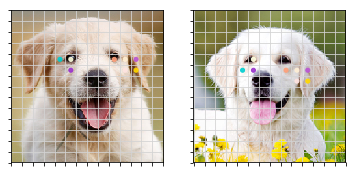

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import colors as mcolors
from random import shuffle

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
shuffle(colors)

def plot_with_grid(subplt, img, n_cells, neigh_rad, nbbs, a_or_b, my_dpi=60):
    ax=plt.subplot(*subplt)
    grid_width = im_a.size[0] / n_cells
    loc = plticker.MultipleLocator(base=grid_width)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='major', axis='both', linestyle='-', color='lightgrey')
    ax.imshow(img)
    nbb_index = 0 if a_or_b == 'a' else 1
    for index, coords in enumerate(nbbs):
        j=grid_width/2+(coords[nbb_index]//(n_cells-2*neigh_rad)+neigh_rad)*grid_width
        i=grid_width/2+(coords[nbb_index]%(n_cells-2*neigh_rad)+neigh_rad)*grid_width
        ax.add_artist(plt.Circle((i, j), 3, color=colors[index], alpha=0.9))
    
plot_with_grid((1,2,1), im_a, feat_a[4].size()[2], 2, nbbs, 'a')
plot_with_grid((1,2,2), im_b, feat_a[4].size()[2], 2, nbbs, 'b')

#### Looks ok. Disappointed that neurons at the tongues and noses were not identified as NBBs